# Boundary layer in transition to turbulence

In this notebook, the GMM unsupervised dominant balance identification method is used for the Reynolds-averaged Navier-Stokes (RANS) equations, in the context of a boundary layer in transition to turbulence.  


The data used is obtained by averages of the Direct Numerical Simulation by Lee & Zaki available from the [Johns Hopkins turbulence database](http://turbulence.pha.jhu.edu/Transition_bl.aspx). In that data are:
- (x,y) coordinates
- u, v, w, and p fields (values over all (x,y)) (time-averaged)
- uu, uv, uw, vv, pp, and up fields (uu is time average of u*u, same for other quantities)


The actual data can be downloaded [here](http://turbulence.pha.jhu.edu/docs/transition_bl/Transition_BL_Time_Averaged_Profiles.h5).


As for the cylinder wake (```Cylinder.ipynb``` notebook), only the streamwise component of the equations are studied:
$$ \bar{u} \bar{u}_x + \bar{v} \bar{u}_y = \rho^{-1} \bar{p}_x + \nu \nabla^2 \bar{u}  - (\overline{u' v'})_y - (\overline{u'^2})_x $$


The main dominant balance clusters expected here are the inertial and viscous sublayers in the turbulent region, where the wall-normal Reynolds stress $(\overline{u' v'})_y$ is balanced by mean flow advection ($\bar{u} \bar{u}_x$) and viscosity ($\nu \nabla^2 \bar{u}$), respectively.


The code in this notebook is based on the code written by Callaham, and is available [here](https://github.com/dynamicslab/dominant-balance).

In [290]:
import numpy as np
from numpy.random import randint
import h5py
import matplotlib.pyplot as plt
import sys
import sklearn as sk
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import SparsePCA
from scipy import sparse
from scipy.optimize import curve_fit, root
from scipy.integrate import odeint
import pandas as pd


# adding Tools to the system path, and importing the modules
sys.path.insert(0, "../Tools/")
import plot_funcs as pf
import blasius_solution as bs
import stability_assessment as sa
import preprocessing as pp

The first step is to load the data and get the terms needed. Recall all variables in the data are already time averaged (i.e. the overbar is already "satisfied")

To get:
- $\bar{u} \bar{u}_x$, u and du/dx are needed
- $\bar{v} \bar{u}_y$, v and du/dy are needed
- $\rho^{-1} \bar{p}_x$, a value for rho can be set, and dp/dx is needed
- $\nu \nabla^2 \bar{u}$, a value for nu and the laplacian of u is needed
- $(\overline{u' v'})_y$, the wall-normal (y-derivative) Reynold's stress term, using the fact that the time average of: u'* u', is given by: uum - (um * um), from Reynold's averaging properties, the variables needed are uv, u, and v.
- $(\overline{u'^2})_x$, the streamwise Reynolds, similarly, the variables needed are uu, and u.

In [291]:
# Load the data from http://turbulence.pha.jhu.edu/Transition_bl.aspx
file = h5py.File("../Data/Transition_BL_Time_Averaged_Profiles.h5", "r")

In [292]:
# Get arrays for variables and the Reynold's averages
x = np.array(file["x_coor"])
y = np.array(file["y_coor"])
u_bar = np.array(file["um"])
v_bar = np.array(file["vm"])
p_bar = np.array(file["pm"])
R_uu = np.array(file["uum"]) - u_bar**2
R_uv = np.array(file["uvm"]) - u_bar * v_bar

To visualise how the boundary layer looks like, a good variable to plot is the Reynold's stress term, which accounts for turbulent fluctuations in the fluid (pp.503-504)[[Boundary-Layer Theory, Schlichting & Gertsen]](https://link.springer.com/book/10.1007/978-3-662-52919-5). Determining the 99-th percentile of the streamwise component u is done following the desription of the simulation from which the data is from: [here](http://turbulence.pha.jhu.edu/docs/README-transition_bl.pdf)

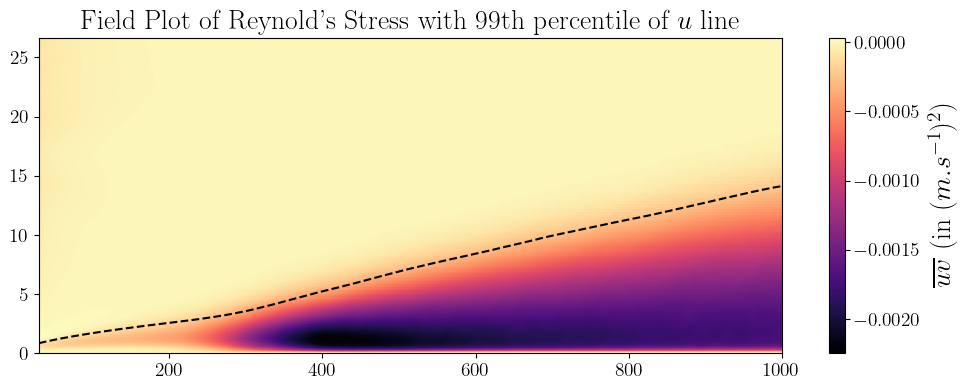

In [293]:
# Since x and y are given as 1D arrays, we need to create a meshgrid to get contours
X, Y = np.meshgrid(x, y)

# Include line of 99% of free flow mean velocity
# Values from http://turbulence.pha.jhu.edu/docs/README-transition_bl.pdf
U_inf = 1  # m/s
nu = 1 / 800  # m^2/s
Re = (U_inf / nu) * x  # Reynolds number (dimensionless)

pf.plot_reynolds_stress(x, y, X, Y, u_bar, R_uv)

## Get the finite difference derivatives to estimate the gradients

Now that the relevant variables have been loaded, the derivative terms need to be computed. Here, the terms needed are:
- $u_{x} = \frac{\partial u}{\partial x}$
- $u_{y} = \frac{\partial u}{\partial y}$
- $p_{x} = \frac{\partial p}{\partial x}$
- The y derivative of the Reynolds stress term: $(\overline{u' v'})_y = \frac{\partial \overline{u' v'}}{\partial y}$
- The x derivative of the other Reynolds stress term: $(\overline{u'^{2}})_x = \frac{\partial \overline{u'^{2}}}{\partial x}$

To do this, the finite difference method is used.

__NOTE: VARIABLE STEP SIZE IN Y DIRECTION ONLY__ from the simulation description [README](http://turbulence.pha.jhu.edu/docs/README-transition_bl.pdf)

In [294]:
# Choose which differentiation method to use:
# 1. Sparce Matrix with scipy.sparse
# 2. "Explicit" gradient calculation with numpy.gradient
method = "numpy"

In [295]:
# Get x space step
dx = x[1] - x[0]
# Number of points in x and y
nx = len(x)
ny = len(y)

if method == "numpy":
    # Get y space steps:
    # The y step is not constant, so we need to calculate it for each point
    dy = np.diff(y[::-1])
    dy = np.append(dy, dy[-1])

    # Get the gradients
    u_x, u_y, lap_u, v_y, p_x, R_uux, R_uvy = pp.get_derivatives_numpy(
        nx, ny, dx, y, u_bar, v_bar, p_bar, R_uu, R_uv
    )

    # Flatten arrays for matrix multiplication, using fortran ordering
    u_bar = u_bar.flatten("F")
    v_bar = v_bar.flatten("F")
    p_bar = p_bar.flatten("F")
    R_uu = R_uu.flatten("F")
    R_uv = R_uv.flatten("F")

else:
    # Get y space steps:
    # The y step is not constant, so we need to calculate it for each point
    dy = y[1:] - y[:-1]

    # Get the derivative sparse matrices
    Dx, Dy = pp.get_derivatives(nx, ny, dx, dy)

    # Get the 2nd derivative sparse matrices
    Dxx = 2 * (Dx @ Dx)
    Dyy = 2 * (Dy @ Dy)

    # Get derivatives
    u_x = Dx @ u_bar
    u_y = Dy @ u_bar
    v_x = Dx @ v_bar
    v_y = Dy @ v_bar
    p_x = Dx @ p_bar
    p_y = Dy @ p_bar
    lap_u = (Dxx + Dyy) @ u_bar
    R_uux = Dx @ R_uu
    R_uvy = Dy @ R_uv

# Flatten the derivative terms arrays for the rest of the notebook
lap_u = lap_u.flatten("F")
R_uux = R_uux.flatten("F")
R_uvy = R_uvy.flatten("F")
u_x = u_x.flatten("F")
u_y = u_y.flatten("F")
v_y = v_y.flatten("F")
p_x = p_x.flatten("F")

## 1. Visualising the RANS equation

In [296]:
# Labels of terms in the RANS equation
labels = [
    r"$\bar{u} \bar{u}_x$",
    r"$\bar{v}\bar{u}_y$",
    r"$\rho^{-1} \bar{p}_x$",
    r"$\nu \nabla^2 \bar{u}$",
    r"$\overline{(u^\prime v^\prime)}_y$",
    r"$\overline{({u^\prime} ^2)}_x$",
]

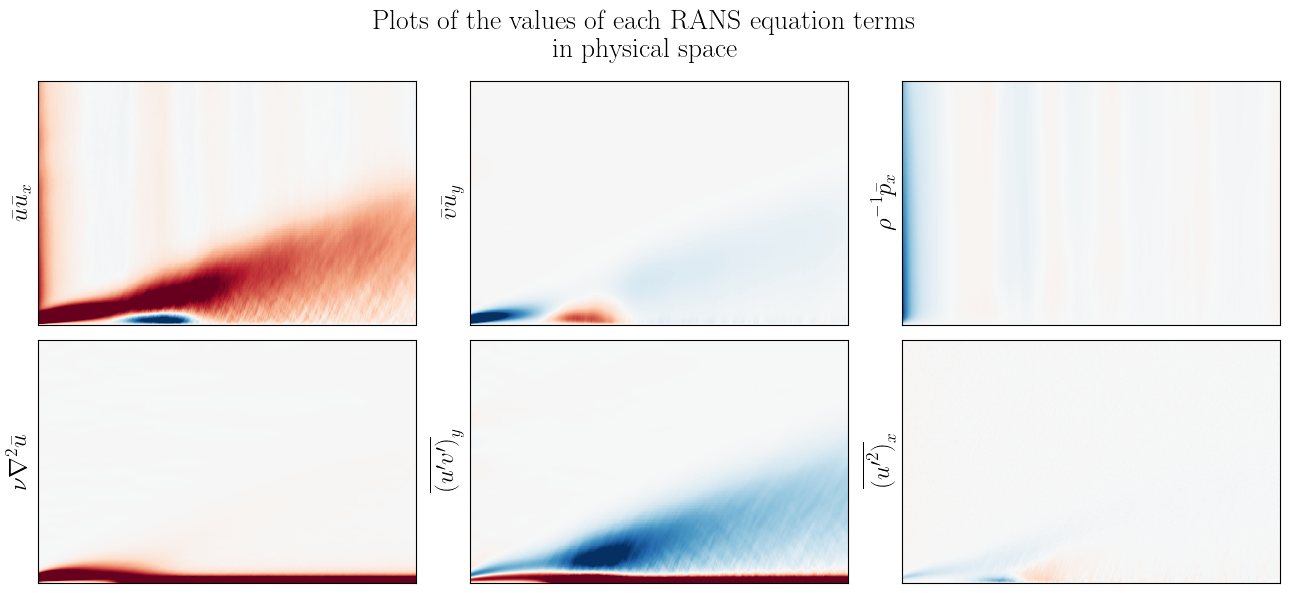

In [297]:
# Plot all six terms in the RANS equation
pf.plot_equation_terms_bound_lay(
    x, y, nx, ny, u_bar, u_x, u_y, v_bar, R_uvy, R_uux, p_x, nu, lap_u
)

## 2. Cluster using Gaussian Mixture Model (GMM)

Since the data is very high resolution, train on 10% randomly subsampled points for better speed.

In [298]:
# Train Gaussian mixture model

# Choose which method to use:
# 1. Original method with numpy
# 2. Alternative method with pandas and sklearn
method = "original"

if method == "original":
    # Gather the terms into an array of features
    features = (
        1e3 * np.vstack([u_bar * u_x, v_bar * u_y, p_x, nu * lap_u, R_uvy, R_uux]).T
    )
    nfeatures = features.shape[1]

    # Fit Gaussian mixture model
    nc = 6  # Number of clusters
    seed = 75016  #  Set a seed for debugging/plotting
    np.random.seed(seed)
    model = GaussianMixture(n_components=nc, random_state=seed)

    # Train on only a subset (10%) of the data
    sample_pct = 0.1
    mask = np.random.permutation(features.shape[0])[
        : int(sample_pct * features.shape[0])
    ]
    model.fit(features[mask, :])

    features_train = features[mask, :]
    clustering_train = model.predict(features_train)

else:
    # Gather the terms into an array of features
    features = 1e3 * pd.DataFrame(
        {
            "uu_x": u_bar * u_x,
            "vu_y": v_bar * u_y,
            "p_x": p_x,
            "nu_lap_u": nu * lap_u,
            "R_uvy": R_uvy,
            "R_uux": R_uux,
        }
    )
    features = features.to_numpy()
    nfeatures = 6

    # Fit Gaussian mixture model
    nc = 6  # Number of clusters
    seed = 75016  #  Set a seed for debugging/plotting
    np.random(seed)
    model = GaussianMixture(n_components=nc, random_state=seed)

    # Train on only a subset (10%) of the data
    sample_pct = 0.1
    features_train, _ = sk.model_selection.train_test_split(
        features, train_size=sample_pct, random_state=seed
    )
    clustering_train = model.fit_predict(features_train)

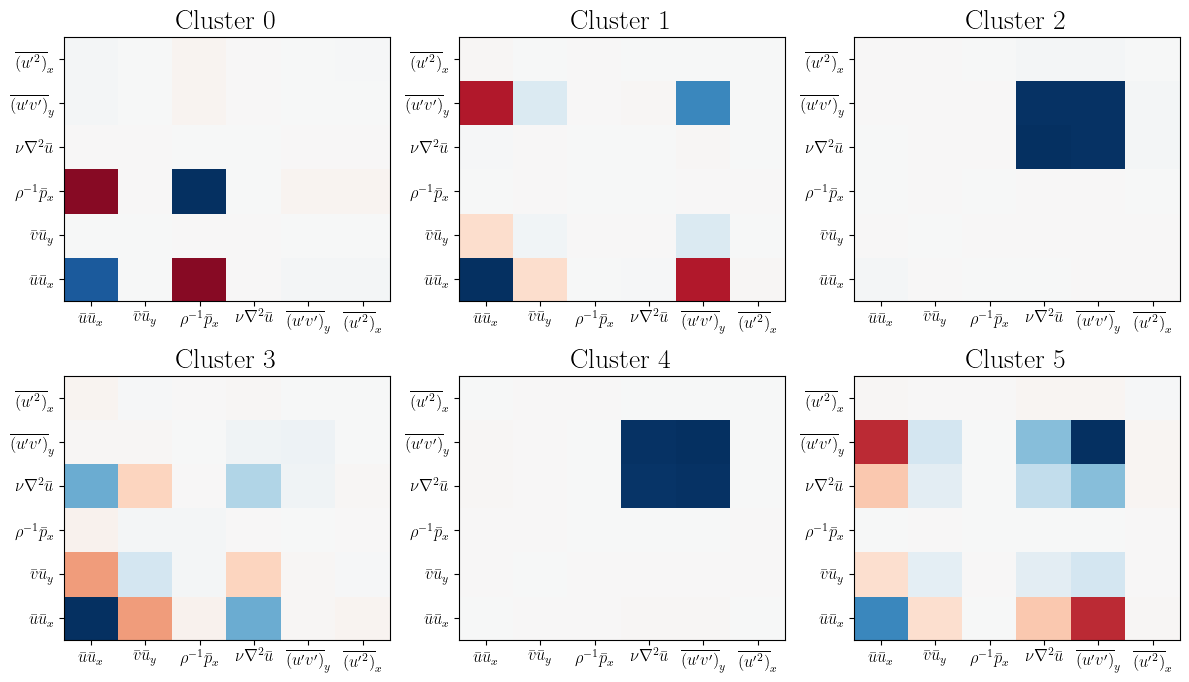

In [299]:
# Plot covariance matrices for each GMM cluster
pf.plot_cov_mat(model, nfeatures, nc, "GMM")

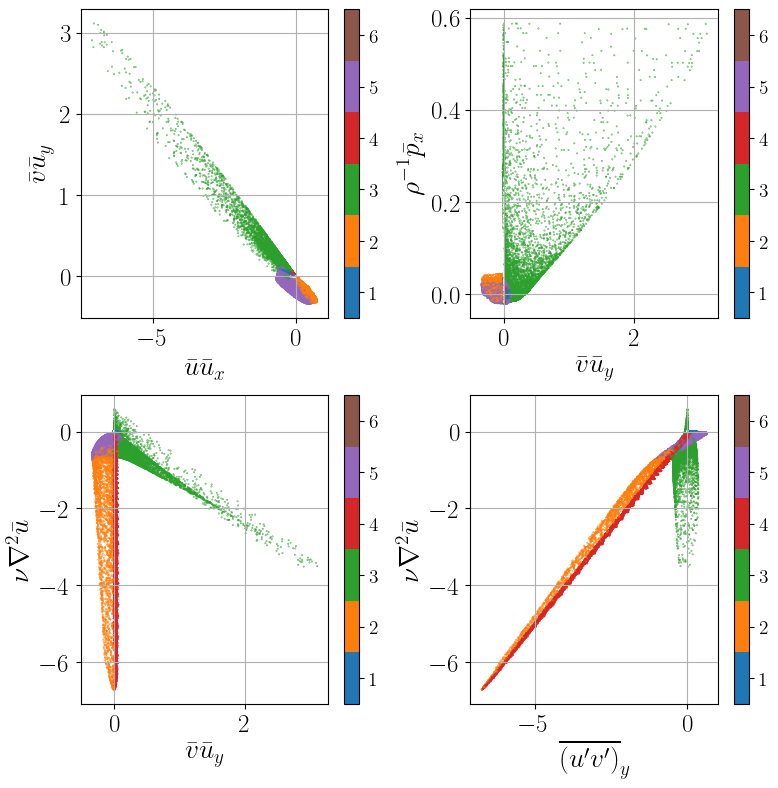

In [300]:
# Visualize GMM clustering with 2D views of equation space
cluster_idx = model.predict(features) + 1

pf.plot_clustering_2d_eq_space(features_train, clustering_train, nc)

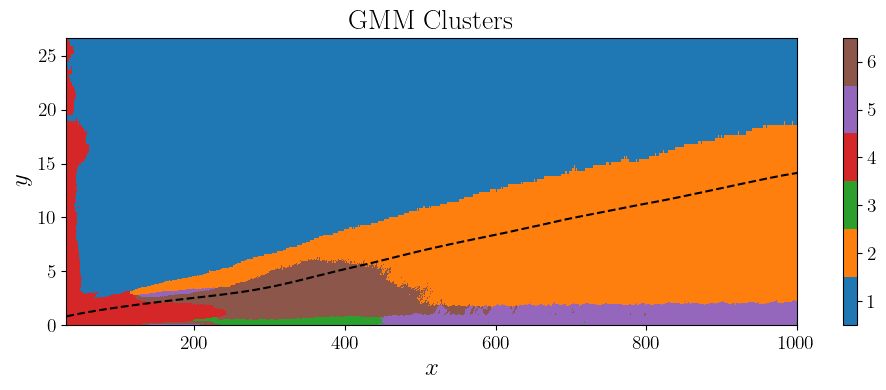

In [301]:
# Assign points in space to each cluster
cluster_idx = cluster_idx - 1
clustermap = np.reshape(cluster_idx, [ny, nx], order="F")

# Visualize the clustering in space
pf.plot_clustering_space(clustermap, x, y, X, Y, nx, ny, nc, u_bar, U_inf)

## 3. Sparce Principal Component Analysis (SPCA) dimensionality reduction

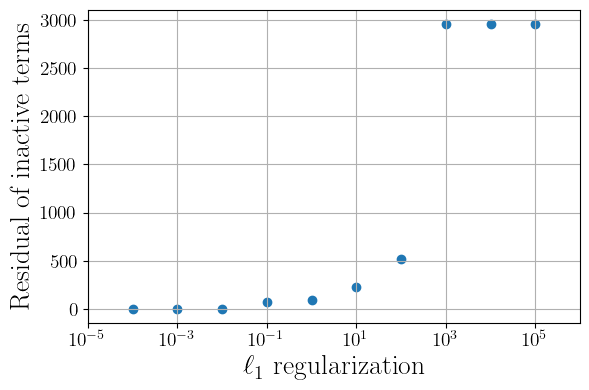

In [302]:
# Sparse PCA to identify directions of nonzero variance in each cluster

# Choose which method to use:
# 1. Original method with numpy
# 2. Alternative method with parallelization

method = "alternative"

if method == "original":
    alphas = [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1e3, 1e4, 1e5]
    err = np.zeros([len(alphas)])

    for k in range(len(alphas)):
        for i in range(nc):
            # Identify points in the field corresponding to each cluster
            feature_idx = np.nonzero(cluster_idx == i)[0]
            cluster_features = features[feature_idx, :]

            # Conduct Sparse PCA
            spca = SparsePCA(
                n_components=1, alpha=alphas[k]
            )  # normalize_components=True
            spca.fit(cluster_features)

            # Identify active and inactive terms
            active_terms = np.nonzero(spca.components_[0])[0]
            inactive_terms = [
                feat for feat in range(nfeatures) if feat not in active_terms
            ]

            # Calculate the error, as the sum of the norms of the inactive terms
            err[k] += np.linalg.norm(cluster_features[:, inactive_terms])


else:
    alphas = [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1e3, 1e4, 1e5]
    err = np.zeros([len(alphas)])

    for k, alpha in enumerate(alphas):
        for i in range(nc):
            # Identify points in the field corresponding to each cluster
            feature_idx = np.where(cluster_idx == i)[0]
            cluster_features = features[feature_idx, :]

            # Conduct Sparse PCA
            spca = SparsePCA(n_components=1, alpha=alphas[k])
            spca.fit(cluster_features)

            # Identify active and inactive terms
            active_terms = np.where(spca.components_[0] != 0)[0]
            inactive_terms = np.where(spca.components_[0] == 0)[0]

            err[k] += np.sqrt(
                np.sum((cluster_features[:, inactive_terms].ravel()) ** 2)
            )


pf.plot_spca_residuals(alphas, err)

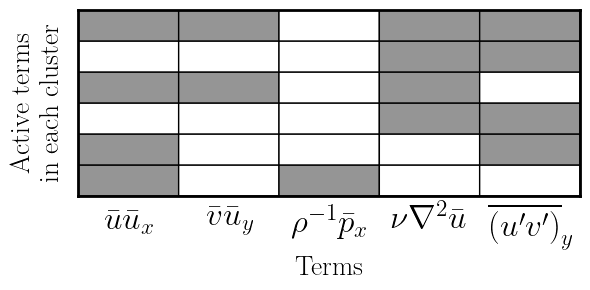

In [312]:
# Get the active terms for each cluster for optimal alpha

alpha_opt = 10  # Optimal alpha value

spca_model = np.zeros([nc, nfeatures])  # Store the active terms for each cluster

if method == "original":
    for i in range(nc):
        feature_idx = np.nonzero(cluster_idx == i)[0]
        cluster_features = features[feature_idx, :]

        spca = SparsePCA(n_components=1, alpha=alpha_opt)  # normalize_components=True
        spca.fit(cluster_features)

        active_terms = np.nonzero(spca.components_[0])[0]
        if len(active_terms) > 0:
            spca_model[i, active_terms] = 1  # Set the active terms to 1
else:
    for i in range(nc):
        feature_idx = np.where(cluster_idx == i)[0]
        cluster_features = features[feature_idx, :]

        spca = SparsePCA(n_components=1, alpha=alpha_opt)  # normalize_components=True
        spca.fit(cluster_features)

        active_terms = np.where(spca.components_[0] != 0)[0]
        if len(active_terms) > 0:
            spca_model[i, active_terms] = 1  # Set the active terms to 1

    pf.plot_active_terms(spca_model, labels)

## 4. Resulting Final Dominant Balance Models

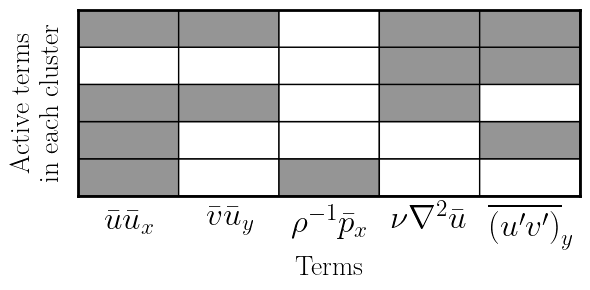

In [317]:
if method == "original":
    # Identify clusters with identical balance models
    balance_models, model_index = np.unique(spca_model, axis=0, return_inverse=True)
    nmodels = balance_models.shape[0]

    # Make new cluster_idx based on the unique SPCA balance model
    balance_idx = np.array([model_index[i] for i in cluster_idx])
    balancemap = np.reshape(balance_idx, [ny, nx], order="F")

    # Plot a grid of the active terms
    pf.plot_active_terms(balance_models, labels)

else:
    # Convert the spca_model array to a dataframe
    spca_temp = pd.DataFrame(spca_model)

    # Group the balance models by the values of all terms
    grouped_models = spca_temp.groupby(np.arange(len(spca_model[0])).tolist())
    grouped_models = grouped_models.groups.items()

    # Combine balance models that have identical active terms
    # For each balance model, the spca models that have the same active terms
    # are given the same index
    model_idx = np.zeros(len(spca_model), dtype=int)
    for i, model in enumerate(grouped_models):
        idx = model[1].to_list()
        model_idx[idx] = i

    # Assign new cluster indices
    balance_idx = np.array([model_index[i] for i in cluster_idx])
    balancemap = np.reshape(balance_idx, [ny, nx], order="F")

    # Get an array of the unique balance models
    balance_models = spca_temp.drop_duplicates(keep="last")
    balance_models = balance_models.to_numpy()

    # Plot a grid of the active terms
    pf.plot_active_terms(balance_models, labels)

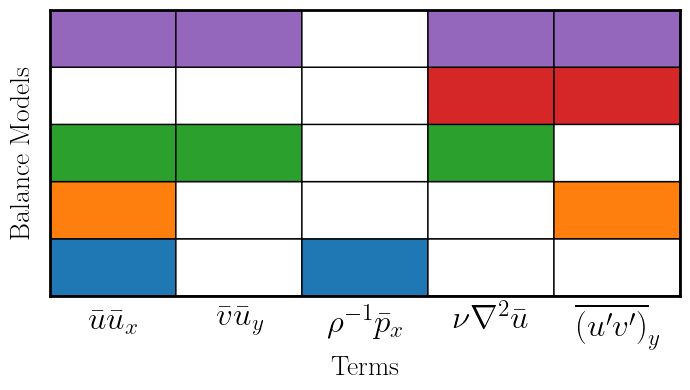

In [314]:
# Plot a grid of the active terms in each cluster
gridmap = balance_models.copy()
gridmask = gridmap == 0
# Make it so rows have each different values so they can be colorcoded
gridmap = (gridmap.T * np.arange(nmodels)).T + 1
gridmap[gridmask] = 0

# Delete terms that are inactive in all clusters
grid_mask = np.where(np.all(gridmap == 0, axis=0))[0]
gridmap = np.delete(gridmap, grid_mask, axis=1)
grid_labels = np.delete(labels, grid_mask)

pf.plot_balance_models(gridmap, grid_labels)

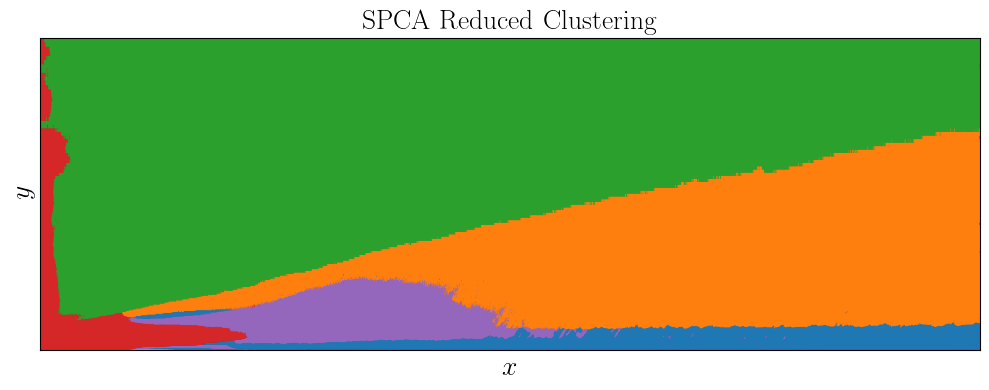

In [315]:
# Plot the clustering in space after SPCA
pf.plot_spca_reduced_clustering(x, y, balancemap)

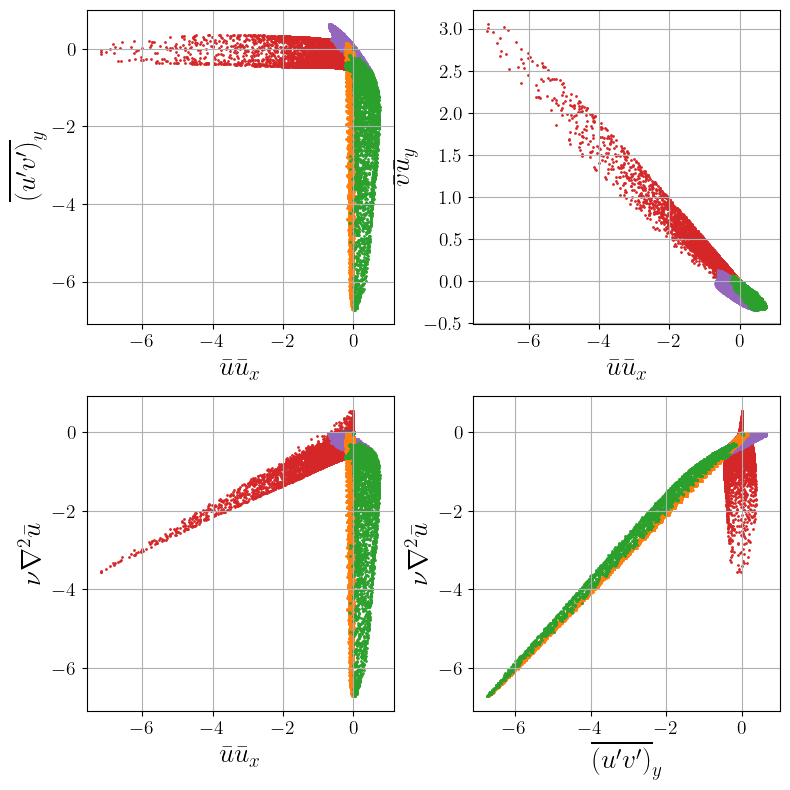

In [156]:
# 2D views of feature space
pf.plot_feature_space(features[mask, :], balance_idx[mask])

## Outer Layer Scaling

The length scale of the outer layer should scale with $ \ell \sim x^{4/5} $ see [p.638] in [Boundary Layer Theory, Schlichting](https://link.springer.com/book/10.1007/978-3-662-52919-5))

As a rough diagnostic of our balance model, define the outer layer length scale as the wall-normal coordinate where the balance changes from the inertial sublayer to the free-stream (once the transitional region has disappeared).

In [330]:
print(np.array(balance_models))
print(np.where(np.all(balance_models == [1.0, 0.0, 0.0, 0.0, 1.0, 0.0], axis=1))[0])

[[1. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0.]
 [1. 1. 0. 1. 0. 0.]
 [0. 0. 0. 1. 1. 0.]
 [1. 1. 0. 1. 1. 0.]]
[1]


[0.06966528 0.81049397]


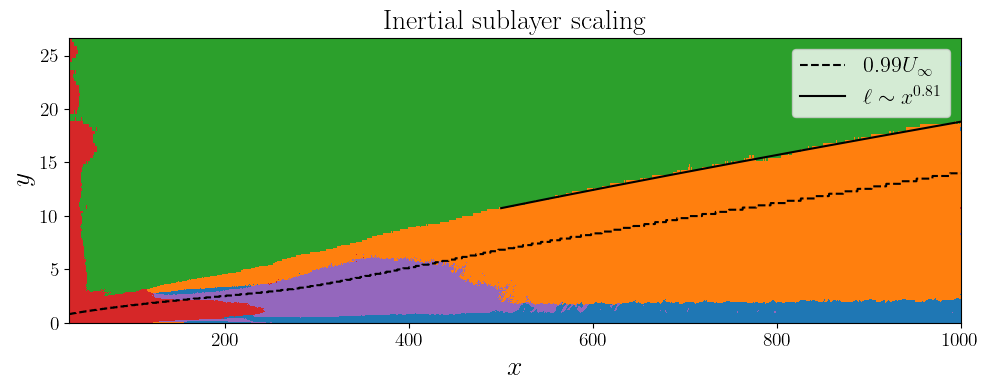

In [331]:
method = "original"

# Create a u_bar field:
u_map = np.reshape(u_bar, (ny, nx), order="F")

# Find which cluster is the inertial sublayer.
inert_sub_idx = np.where(np.all(balance_models == [1, 0, 0, 0, 1, 0]))[0] + 1

# Define some variables
x_min = 110  # Where inertial balance begins
x_turb = 500  # Where transitional region ends

x_idx = np.nonzero(x > x_min)[0]
x_layer = x[x_idx]

# First, find the upper extent of the inertial sublayer
y_gmm = np.zeros(len(x_idx))
# Loop through wall-normal direction until the balance changes
for i in range(len(x_idx)):
    j = len(y) - 1
    while balancemap[j, x_idx[i]] == inert_sub_idx:
        j -= 1
    y_gmm[i] = y[j]  # Store upper value of inertial balance

# Next, find the 99% of free stream velocity line
delta = np.zeros(len(x))
# Loop until velocity falls past 99% freestream
for i in range(len(x)):
    j = 0
    while u_map[j, i] < 0.99:
        j += 1
    delta[i] = y[j - 1]

# Fit inertial balance to power law
power_law = lambda x, a, b: a * x**b

x_to_fit = x_layer > x_turb  # End of transitional region
p_gmm, cov = curve_fit(power_law, x_layer[x_to_fit], y_gmm[x_to_fit])
gmm_fit = power_law(x_layer, *p_gmm)
print(p_gmm)

# Plot the inertial sublayer scaling
pf.plot_sublayer_scaling(x, y, balancemap, delta, x_layer, gmm_fit, p_gmm, x_to_fit)

## Self-similarity

In the near-wall region (viscous sublayer), we should be able to collapse the profiles using wall units $u^+$, $y^+$. These wall units are defined as: 
- $y^{+}=\frac{y u_{\tau}}{\nu}$, the distance $y$ to the wall, dimensionaless using friction velocity $u_{\tau}$, and kinematic viscosity $\nu$.
- $u^{+}=\frac{u}{u_{\tau}}$, the dimensonless velocity as a function of y.

Here we show that this universality breaks down at approximately the same place where the identified viscous sublayer balance ends. Therefore demonstrating the identified balance models follow fluid dynamics theory.

As shown in the figure above, the wall-normal extent of the sublayer (blue) is approximately constant in the fully-developed turbulent region. We show below that this corresponds to $y^+ \sim 70$.

[Wikipedia](https://en.wikipedia.org/wiki/Law_of_the_wall)

67.49237369276939
68.98554004881876
69.15363892371022
74.72988433226698
79.02612065375149


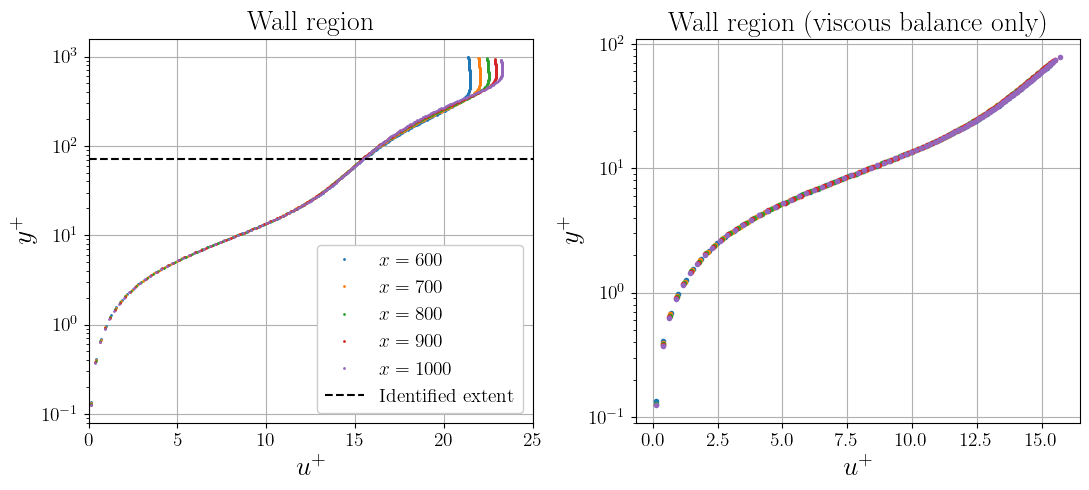

In [ ]:
# Compute friction velocity with an estimate of the wall shear stress
u_tau = np.sqrt(nu * u_y[::ny])

# Define wall units
y_plus = np.outer(y, u_tau / nu)
u_plus = np.reshape(u_bar, [ny, nx], order="F") / u_tau

# Plot the self-similarity of the flow
pf.plot_self_similarity(x, 0, y_plus, u_plus, balancemap)

## Blasius solution in laminar regime

We also find that there is an inflow region without significant Reynolds stress (red), which suggests this flow is approximately laminar, until the transitional (orange) region begins around $x\sim 105$.  Before that we would expect the Blasius boundary layer solution to hold.

__Blasius solution:__
$$ \eta = y \sqrt{\frac{U}{2\nu x} }$$
$$ u = U f'(\eta) $$
[Wikipedia](https://en.wikipedia.org/wiki/Blasius_boundary_layer#Blasius_equation_-_first-order_boundary_layer)

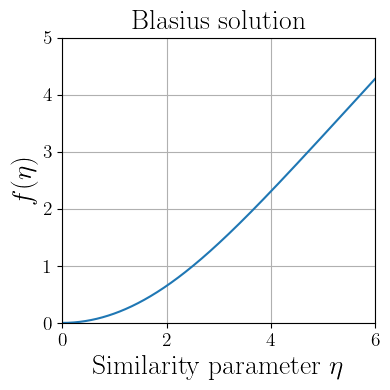

In [ ]:
# Solve Blasius equations numerically

# Arbitrary "infinite" upper limit for domain
eta_inf = 200
# Step size
d_eta = 0.01
eta = np.arange(0, eta_inf, d_eta)

# Initial guess for unknown initial condition
F_init = [0, 0, 0]

# Solve root-finding problem for unknown initial condition
opt_res = root(bs.bc_fn, F_init, tol=1e-4)
F0 = [0, 0, opt_res.x[2]]

# Evaluate with resulting initial conditions
f = odeint(lambda y, t: bs.blasius_rhs(y), F0, eta)

pf.plot_blasius_solution(eta, f)

Then we can compare the inflow profile to the Blasius solution (dotted lines indicate region where the transitional balance begins, after $x \sim 150$.  Until that point there is a maximum deviation of about 6% from the Blasius solution.

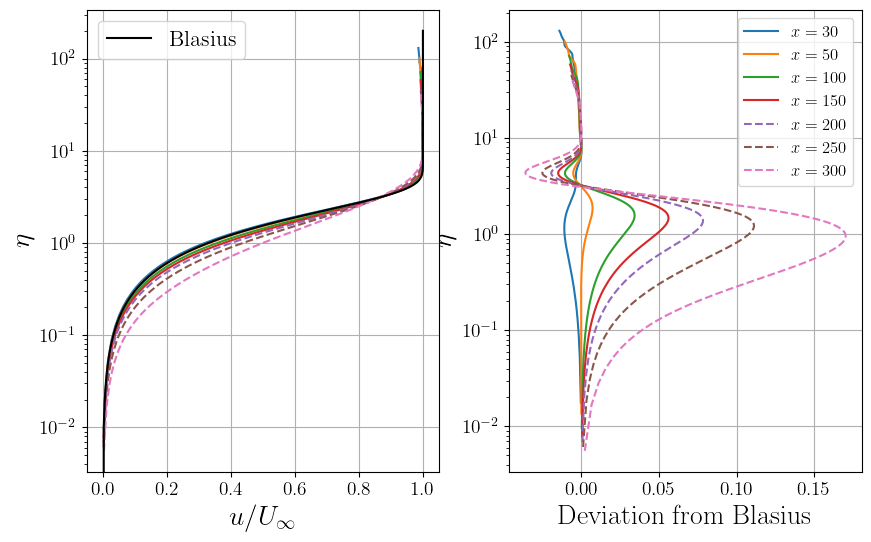

In [ ]:
pf.plot_blasius_deviation(x, y, nx, ny, u_bar, eta, f, U_inf, nu)